 ##   INCIDENT MANAGEMENT  PROCESS IMPROVEMENT        

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
%matplotlib inline
sns.set()

sns.set(style='ticks', context='notebook')
sns.set(font_scale=3.0)
plt.rcParams['figure.figsize'] = [30, 25]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams["axes.labelsize"] = 30

In [184]:
#Loading data
file = 'incident_event_log.csv'
inc_event = pd.read_csv(file)


In [185]:
#coverting this data to a panda dataframe for further data wrangling

inc_eventdf = pd.DataFrame(inc_event)
pd.options.display.max_columns = None

In [186]:
#to replace missing value symbol '?' to NaN
inc_eventdf = inc_eventdf.replace(to_replace=['?'],value = [np.nan]) 

In [187]:
col_name = ['sys_created_at','opened_at','sys_updated_at','resolved_at','closed_at']
for i in range(len(col_name)):
    inc_eventdf[col_name[i]] = pd.to_datetime(inc_eventdf[col_name[i]], dayfirst = True)

In [188]:
# filling all the missing value in resolved_at colums with information in sys_updated_at
# sys_updated_at time corresponding to 'Resolved' state in incident_state
# and using ffill to fill the missing value where the incident_state is 'Closed'

m = inc_eventdf.incident_state == 'Resolved'
y = inc_eventdf.resolved_at.isnull()
c =inc_eventdf.incident_state == 'Closed'
inc_eventdf['resolved_at'] = np.where(m & y,inc_eventdf['sys_updated_at'],inc_eventdf['resolved_at'])
inc_eventdf['resolved_at']= np.where(c & y,inc_eventdf['resolved_at'].ffill(axis=0),inc_eventdf['resolved_at'])

In [189]:
# Dropping all the rows where above trick did not resolve the “resolved_at” missing issue 
# Creating two diffrent list for collecting index information for where "incident_state" is '-100'
# And "resolved_at" is null then using for loop to add them in inc_remove and then droping them.

drop_index1 = inc_eventdf[inc_eventdf['incident_state']== '-100'].number.value_counts().index
drop_index = inc_eventdf[inc_eventdf.resolved_at.isnull()].number.value_counts().index
inc_remove = []

for i,j in enumerate(drop_index1):
    inc_name = inc_eventdf.loc[inc_event.number == j].index
    inc_remove.extend(inc_name)
    
    
for i,j in enumerate(drop_index):
    inc_name = inc_eventdf.loc[inc_event.number == j].index
    inc_remove.extend(inc_name)    
    
inc_eventdf = inc_eventdf.drop(inc_eventdf.loc[inc_remove].index) 
inc_eventdf.reset_index(inplace= True)
inc_eventdf.drop(['index'],axis=1,inplace=True)


In [190]:
inc_eventdf.number.nunique()

24902

## how to work with complete logs

In [191]:
# As Closed is the last stage of the ticket filtering the dataset for just the incident_state 'Closed'
# The number of the unique incident is 24918 and this is more than that there is must be more dublicate incidents 
# For the sake of this project we need the last stage of the ticket hence selecting the last duplicate and reindexing for further use


inc_closed = inc_eventdf.loc[inc_eventdf['incident_state'] == 'Closed', :].copy()
inc_closed.drop_duplicates(subset = 'number',keep='last',inplace = True)
inc_closed.reset_index(inplace = True)
inc_closed.drop(['index'], axis=1,inplace = True)

### Function for adding percetage on barchart


In [192]:
def bar_perc(ax):
    
   
    totals = [] #create a empty list
    
    for i in ax.patches:             #ax.patches to select each bar as a rectangle
        totals.append(i.get_height()) # .get_height() is used for vertical bar chart use .get_width() for horizontal()
    
    
    total = sum(totals) # for geting total no of elements with height as proxy
    
    
    for i in ax.patches:
        ax.text(i.get_x()+0.15, i.get_height()+100, \
            str(round((i.get_height()/total)*100, 2))+'%',color='black')

# .get_x() gets the starting x-axis and for y-axis use .get_height

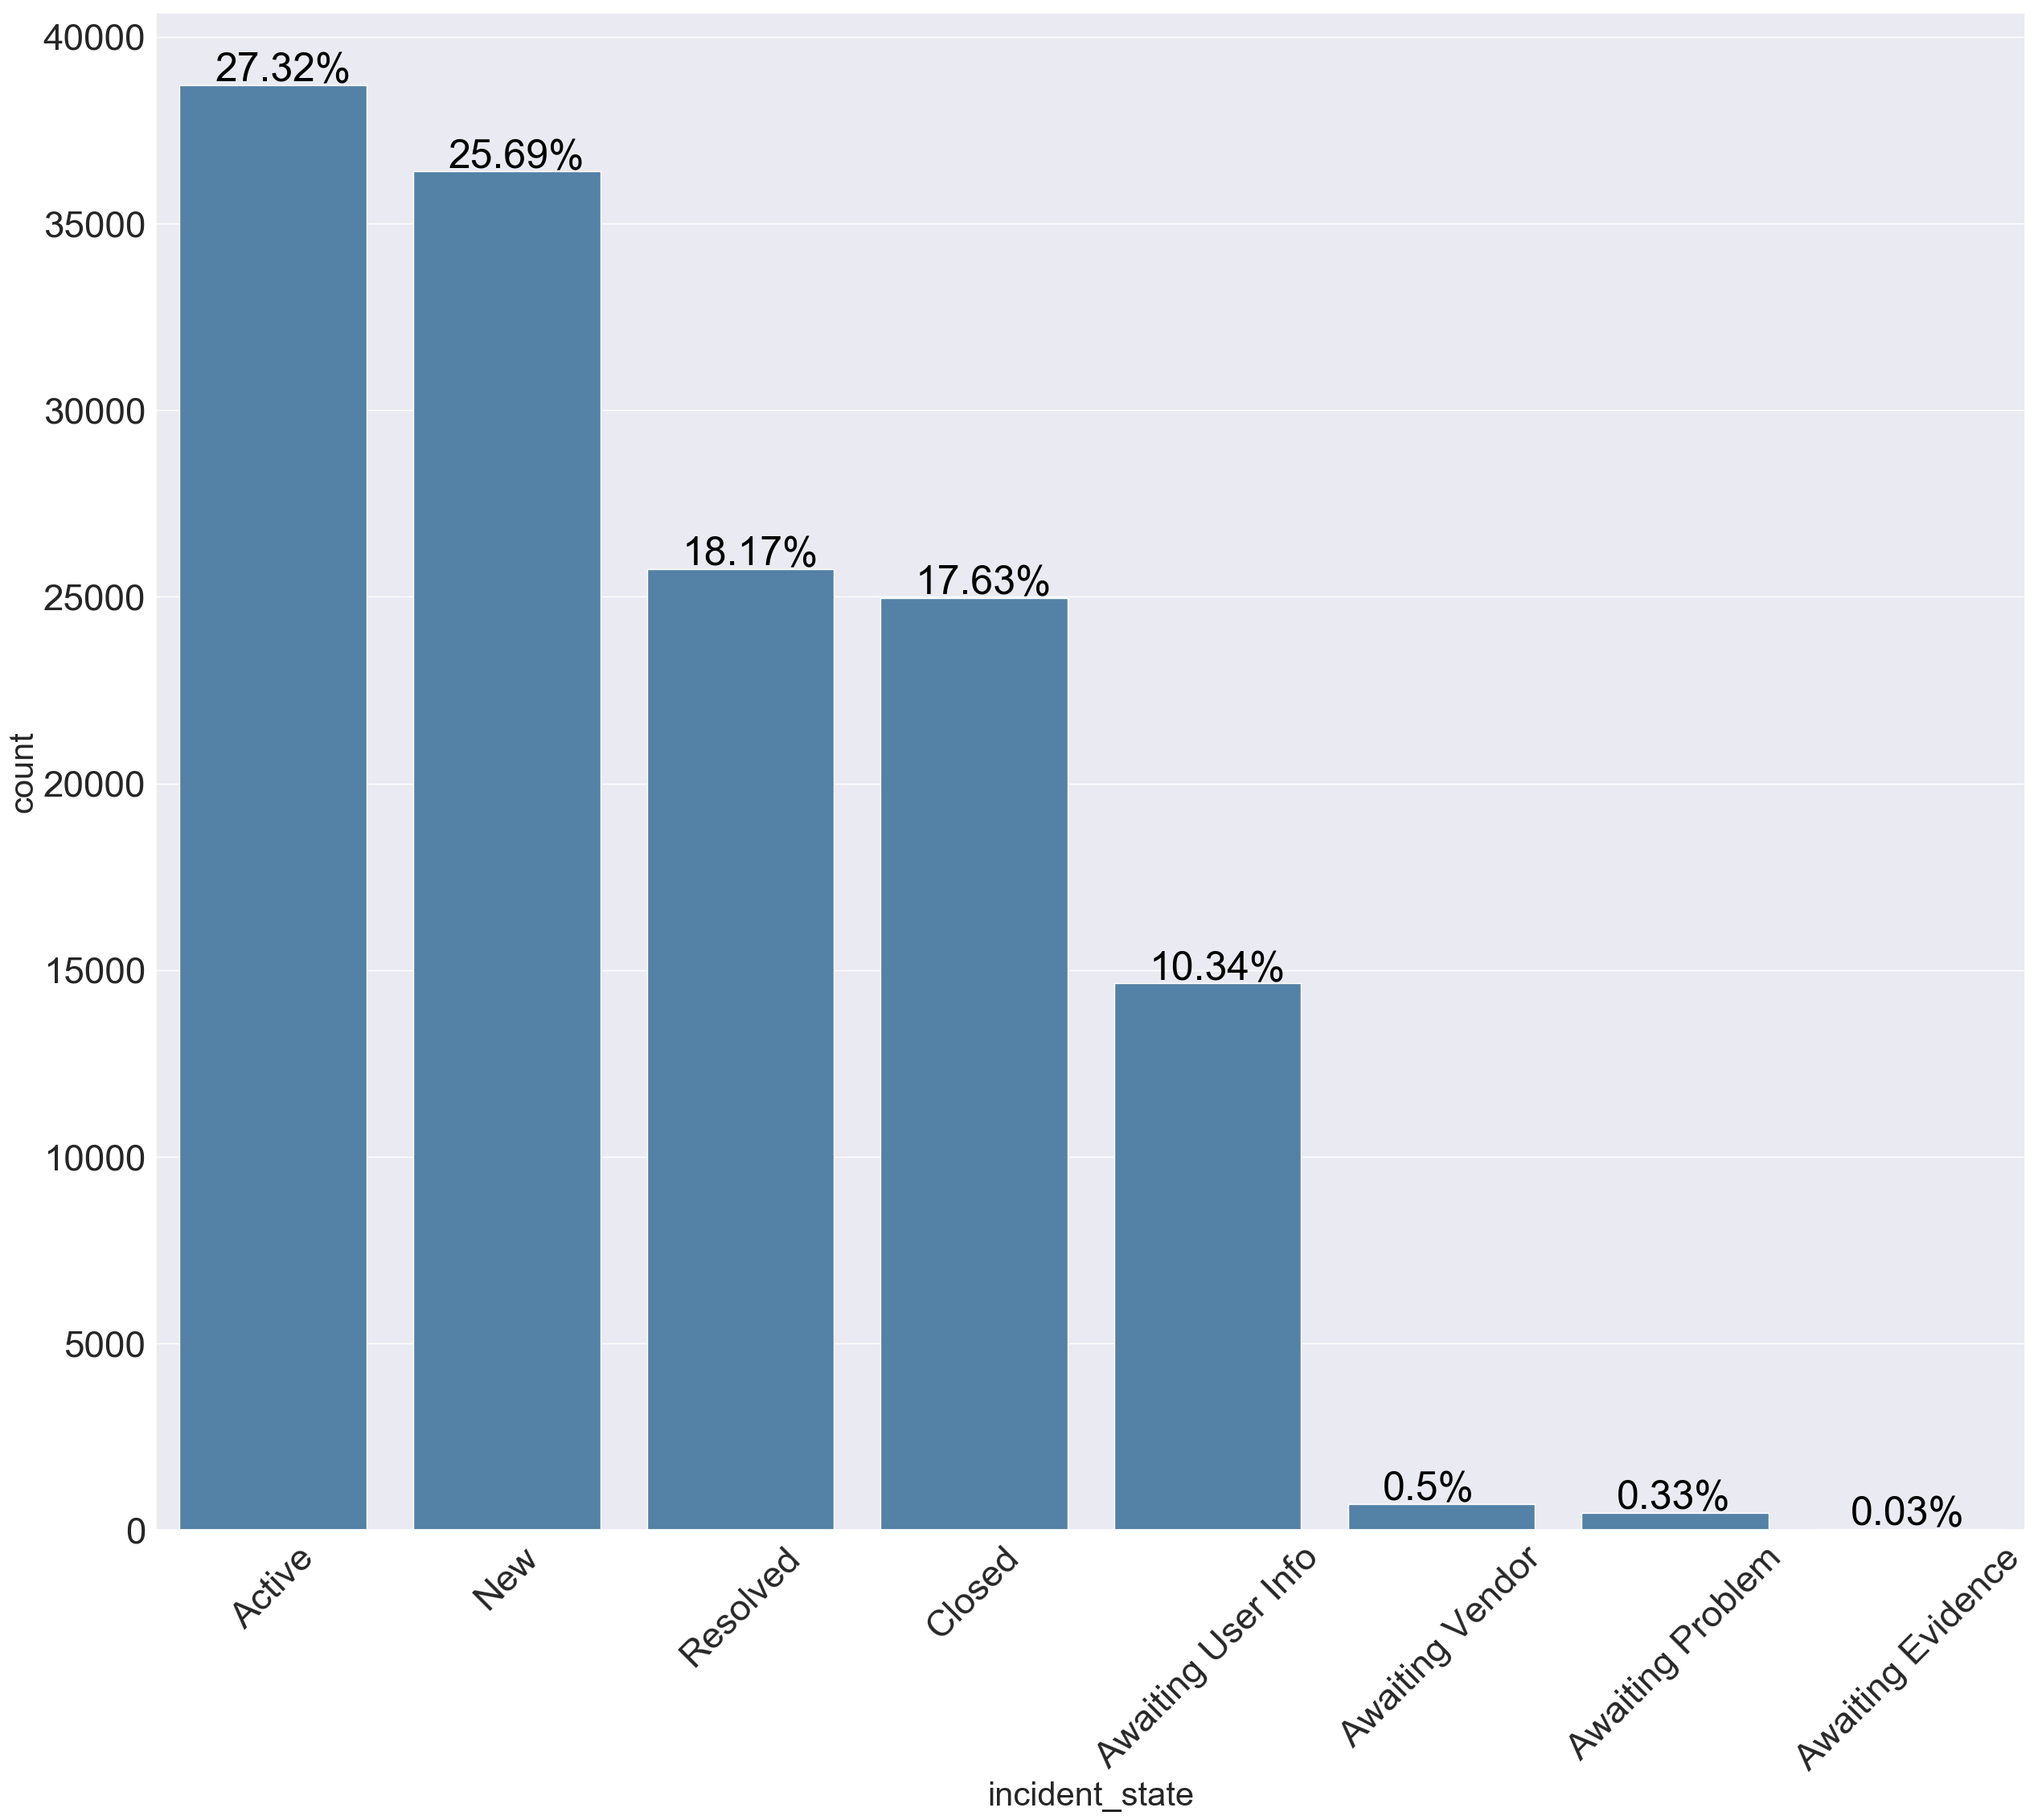

In [193]:
ascending_order = inc_eventdf['incident_state'].value_counts().sort_values(ascending=False).index
plot1 =sns.countplot(data = inc_eventdf, x = 'incident_state',order = ascending_order,color= "steelblue")
plt.xticks(rotation=45)
bar_perc(plot1)

### Unable to get fuction bar_perc to work while "order" parameter is used.

fig, axes = plt.subplots(2,2)

sns.countplot(ax=axes[0,0],data = inc_closed, x ='impact' ,color= "steelblue",order = ['1 - High','2 - Medium','3 - Low '])
sns.countplot(ax=axes[0,1],data = inc_closed, x ='contact_type' ,color= "steelblue",order = ['Phone','Self service','Email','Direct opening '])
sns.countplot(ax=axes[1,0],data = inc_closed, x ='urgency' ,color= "steelblue",order = ['1 - High','2 - Medium','3 - Low '])
sns.countplot(ax=axes[1,1],data = inc_closed, x ='priority' ,color= "steelblue",order = ['1 - Critical','2 - High','3 - Moderate','4 - Low'])


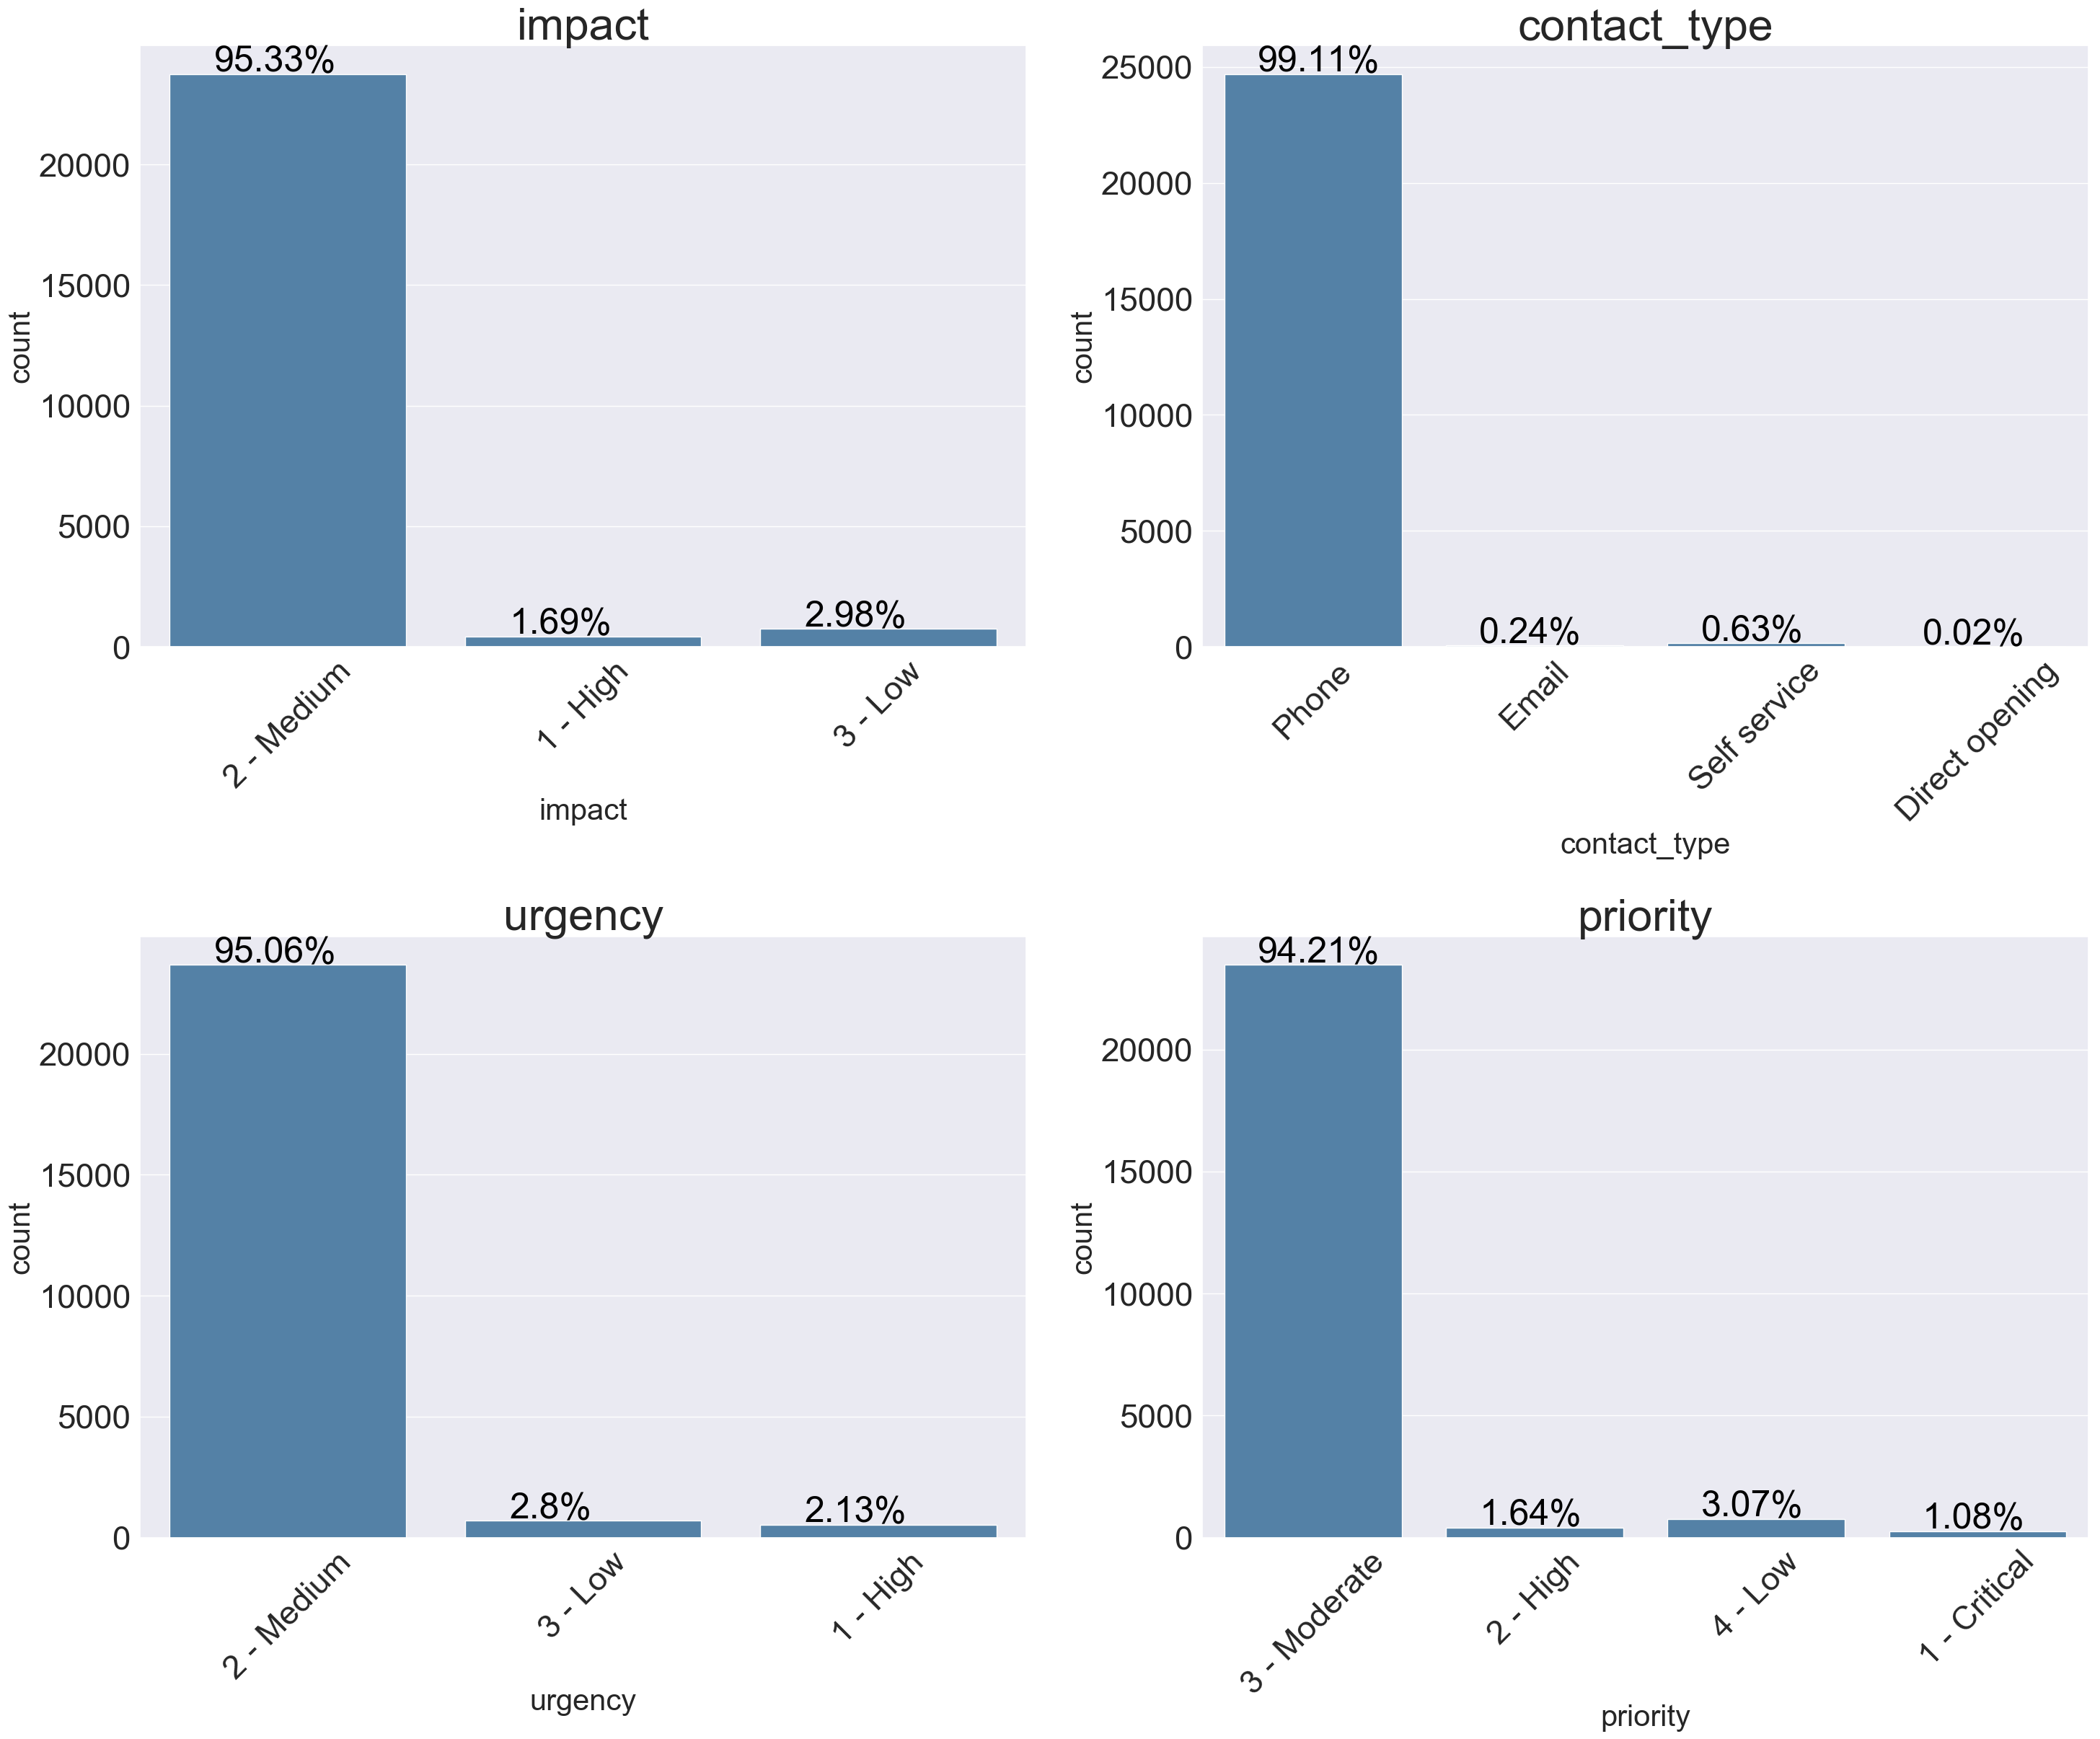

In [194]:
colname = ['impact','contact_type','urgency','priority']
order_list =[['1 - High','2 - Medium','3 - Low '],['Phone','Self service','Email','Direct opening '],['1 - High','2 - Medium','3 - Low '],['1 - Critical','2 - High','3 - Moderate','4 - Low']]


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    
    ax= sns.countplot(data = inc_closed, x = j,color= "steelblue") ##,order = order_list[i] (if this is added there is error)
       
    plt.xticks(rotation=45)
    plt.title((j), fontsize = 45)
    bar_perc(ax)

plt.tight_layout()

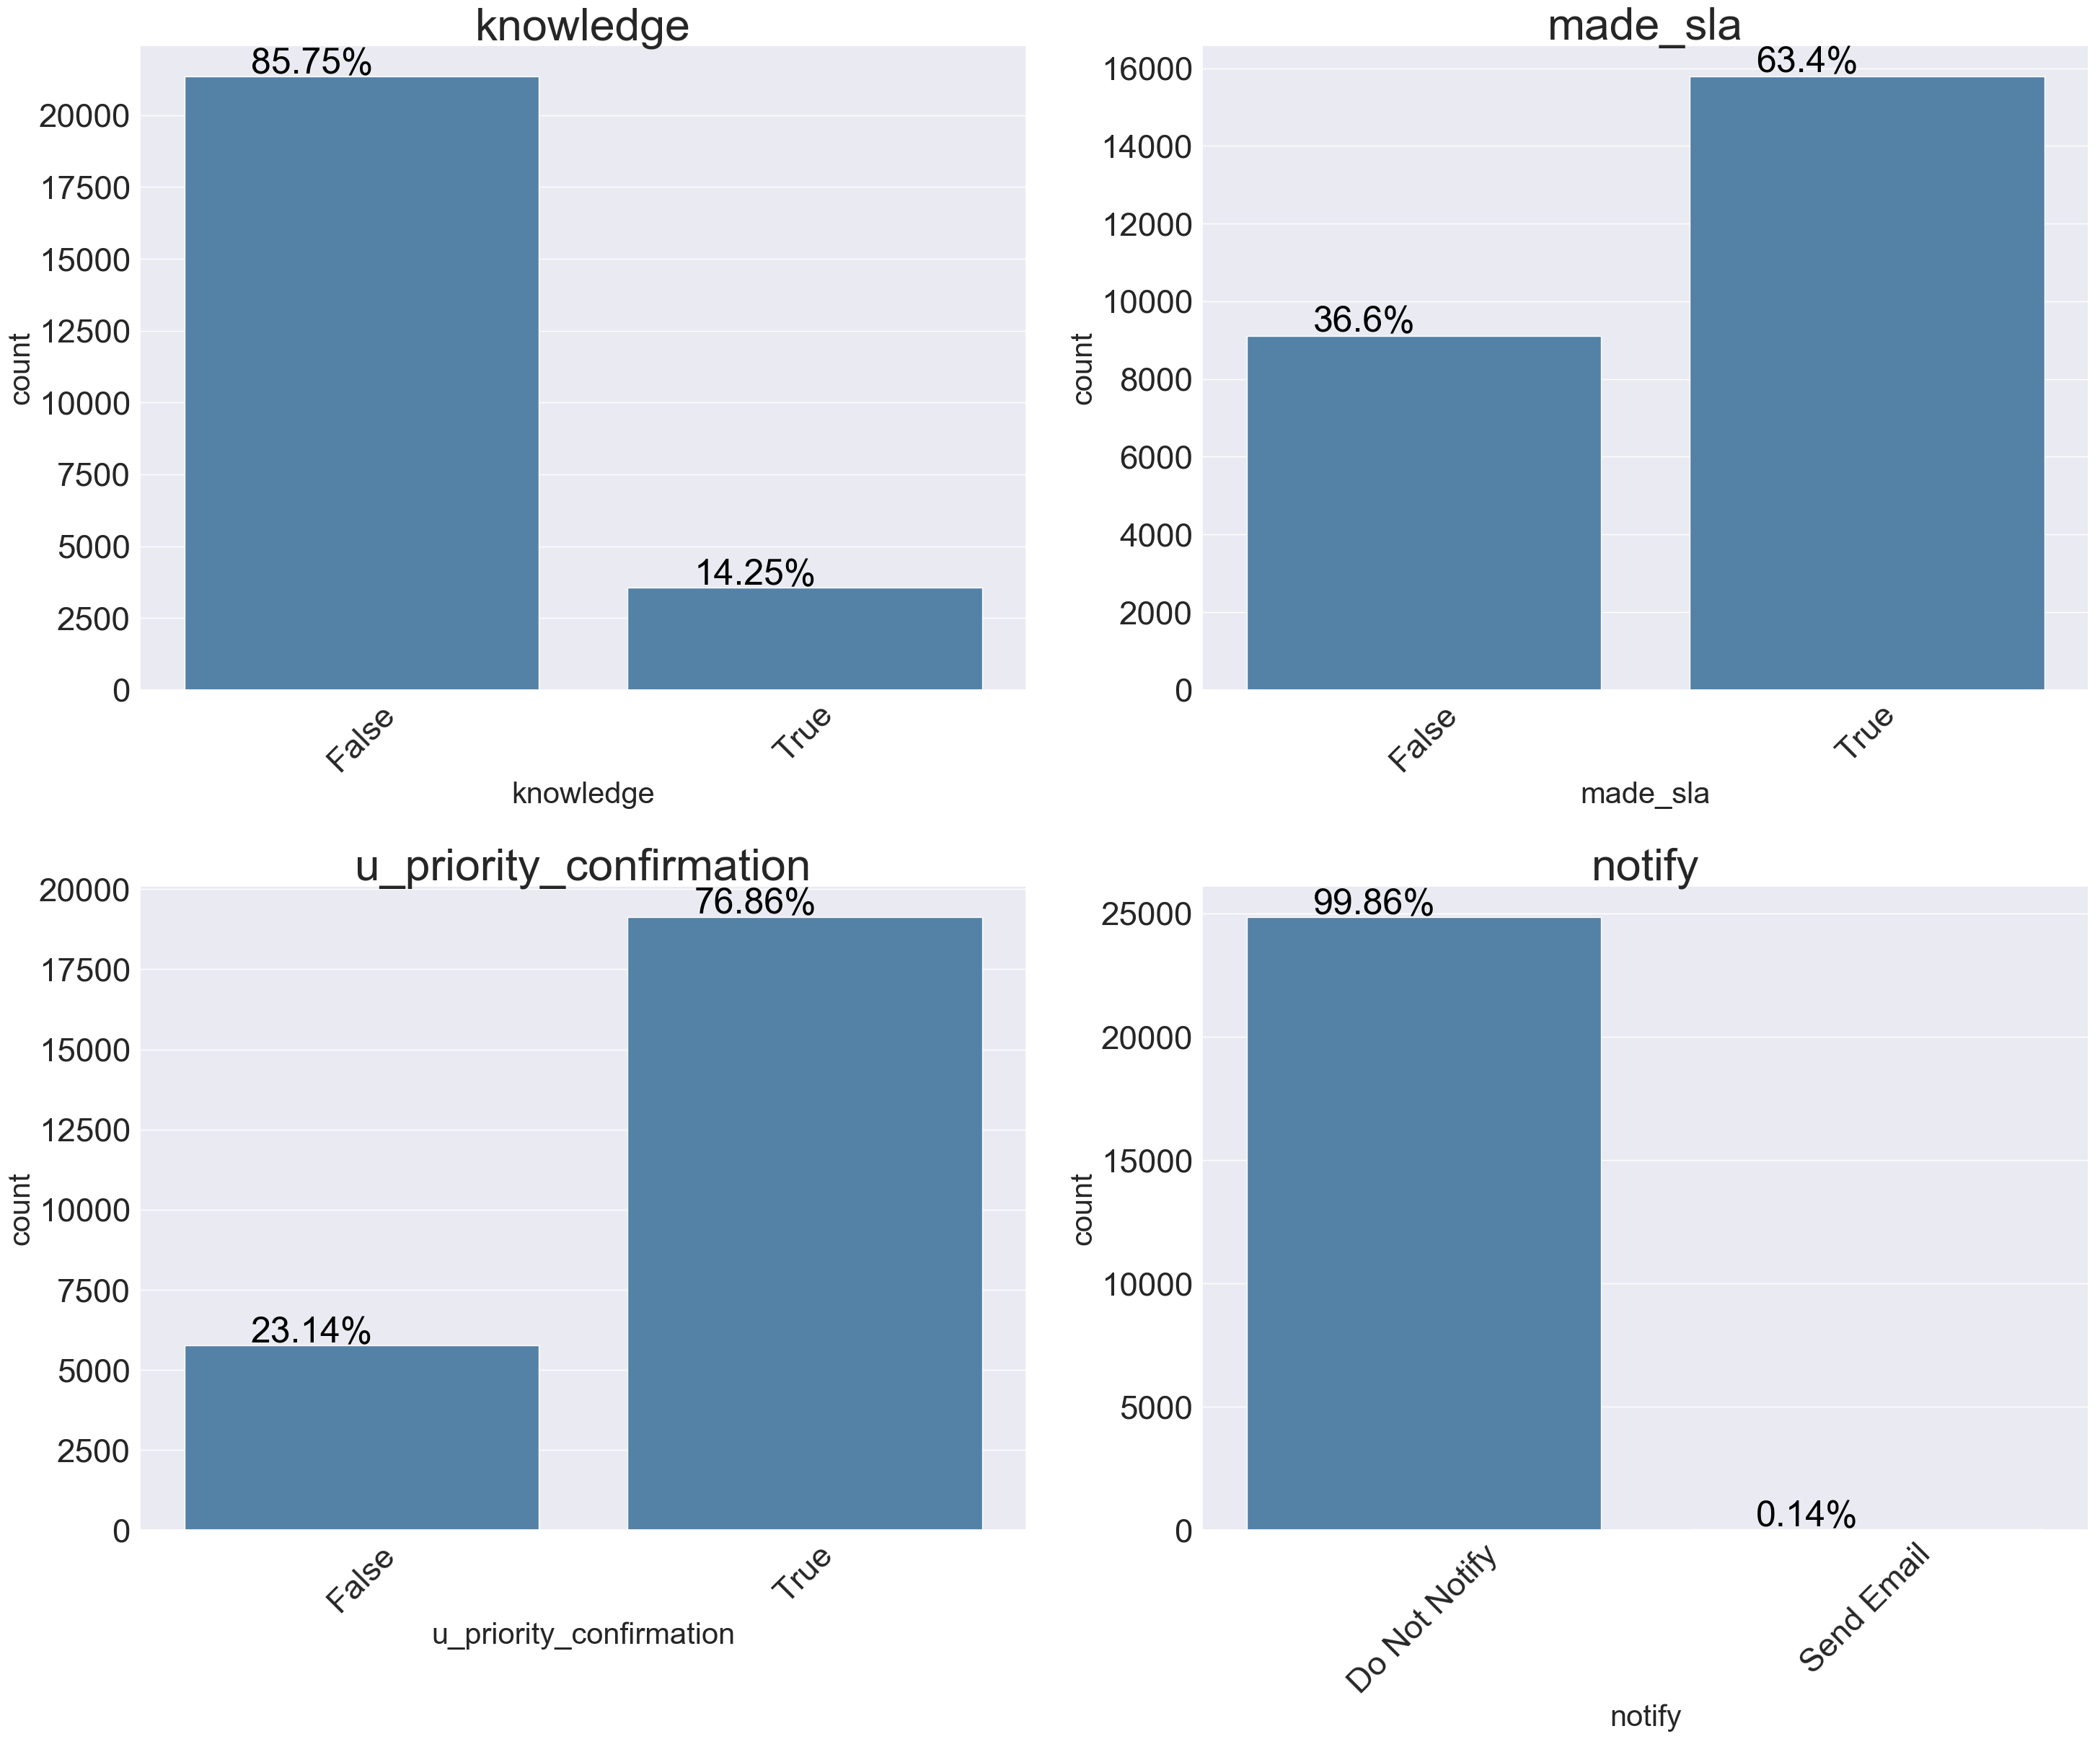

In [195]:
colname = ['knowledge','made_sla','u_priority_confirmation','notify']


for i,j in enumerate(colname):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(data = inc_closed, x = j,color= "steelblue")
    bar_perc(ax)
    plt.xticks(rotation=45)
    plt.title((j), fontsize = 45)

plt.tight_layout()



### Distribution of number of tickets opened every hour of the day.

Text(0.5, 1.0, 'Number of tickets opened Vs resolved each hour of the day')

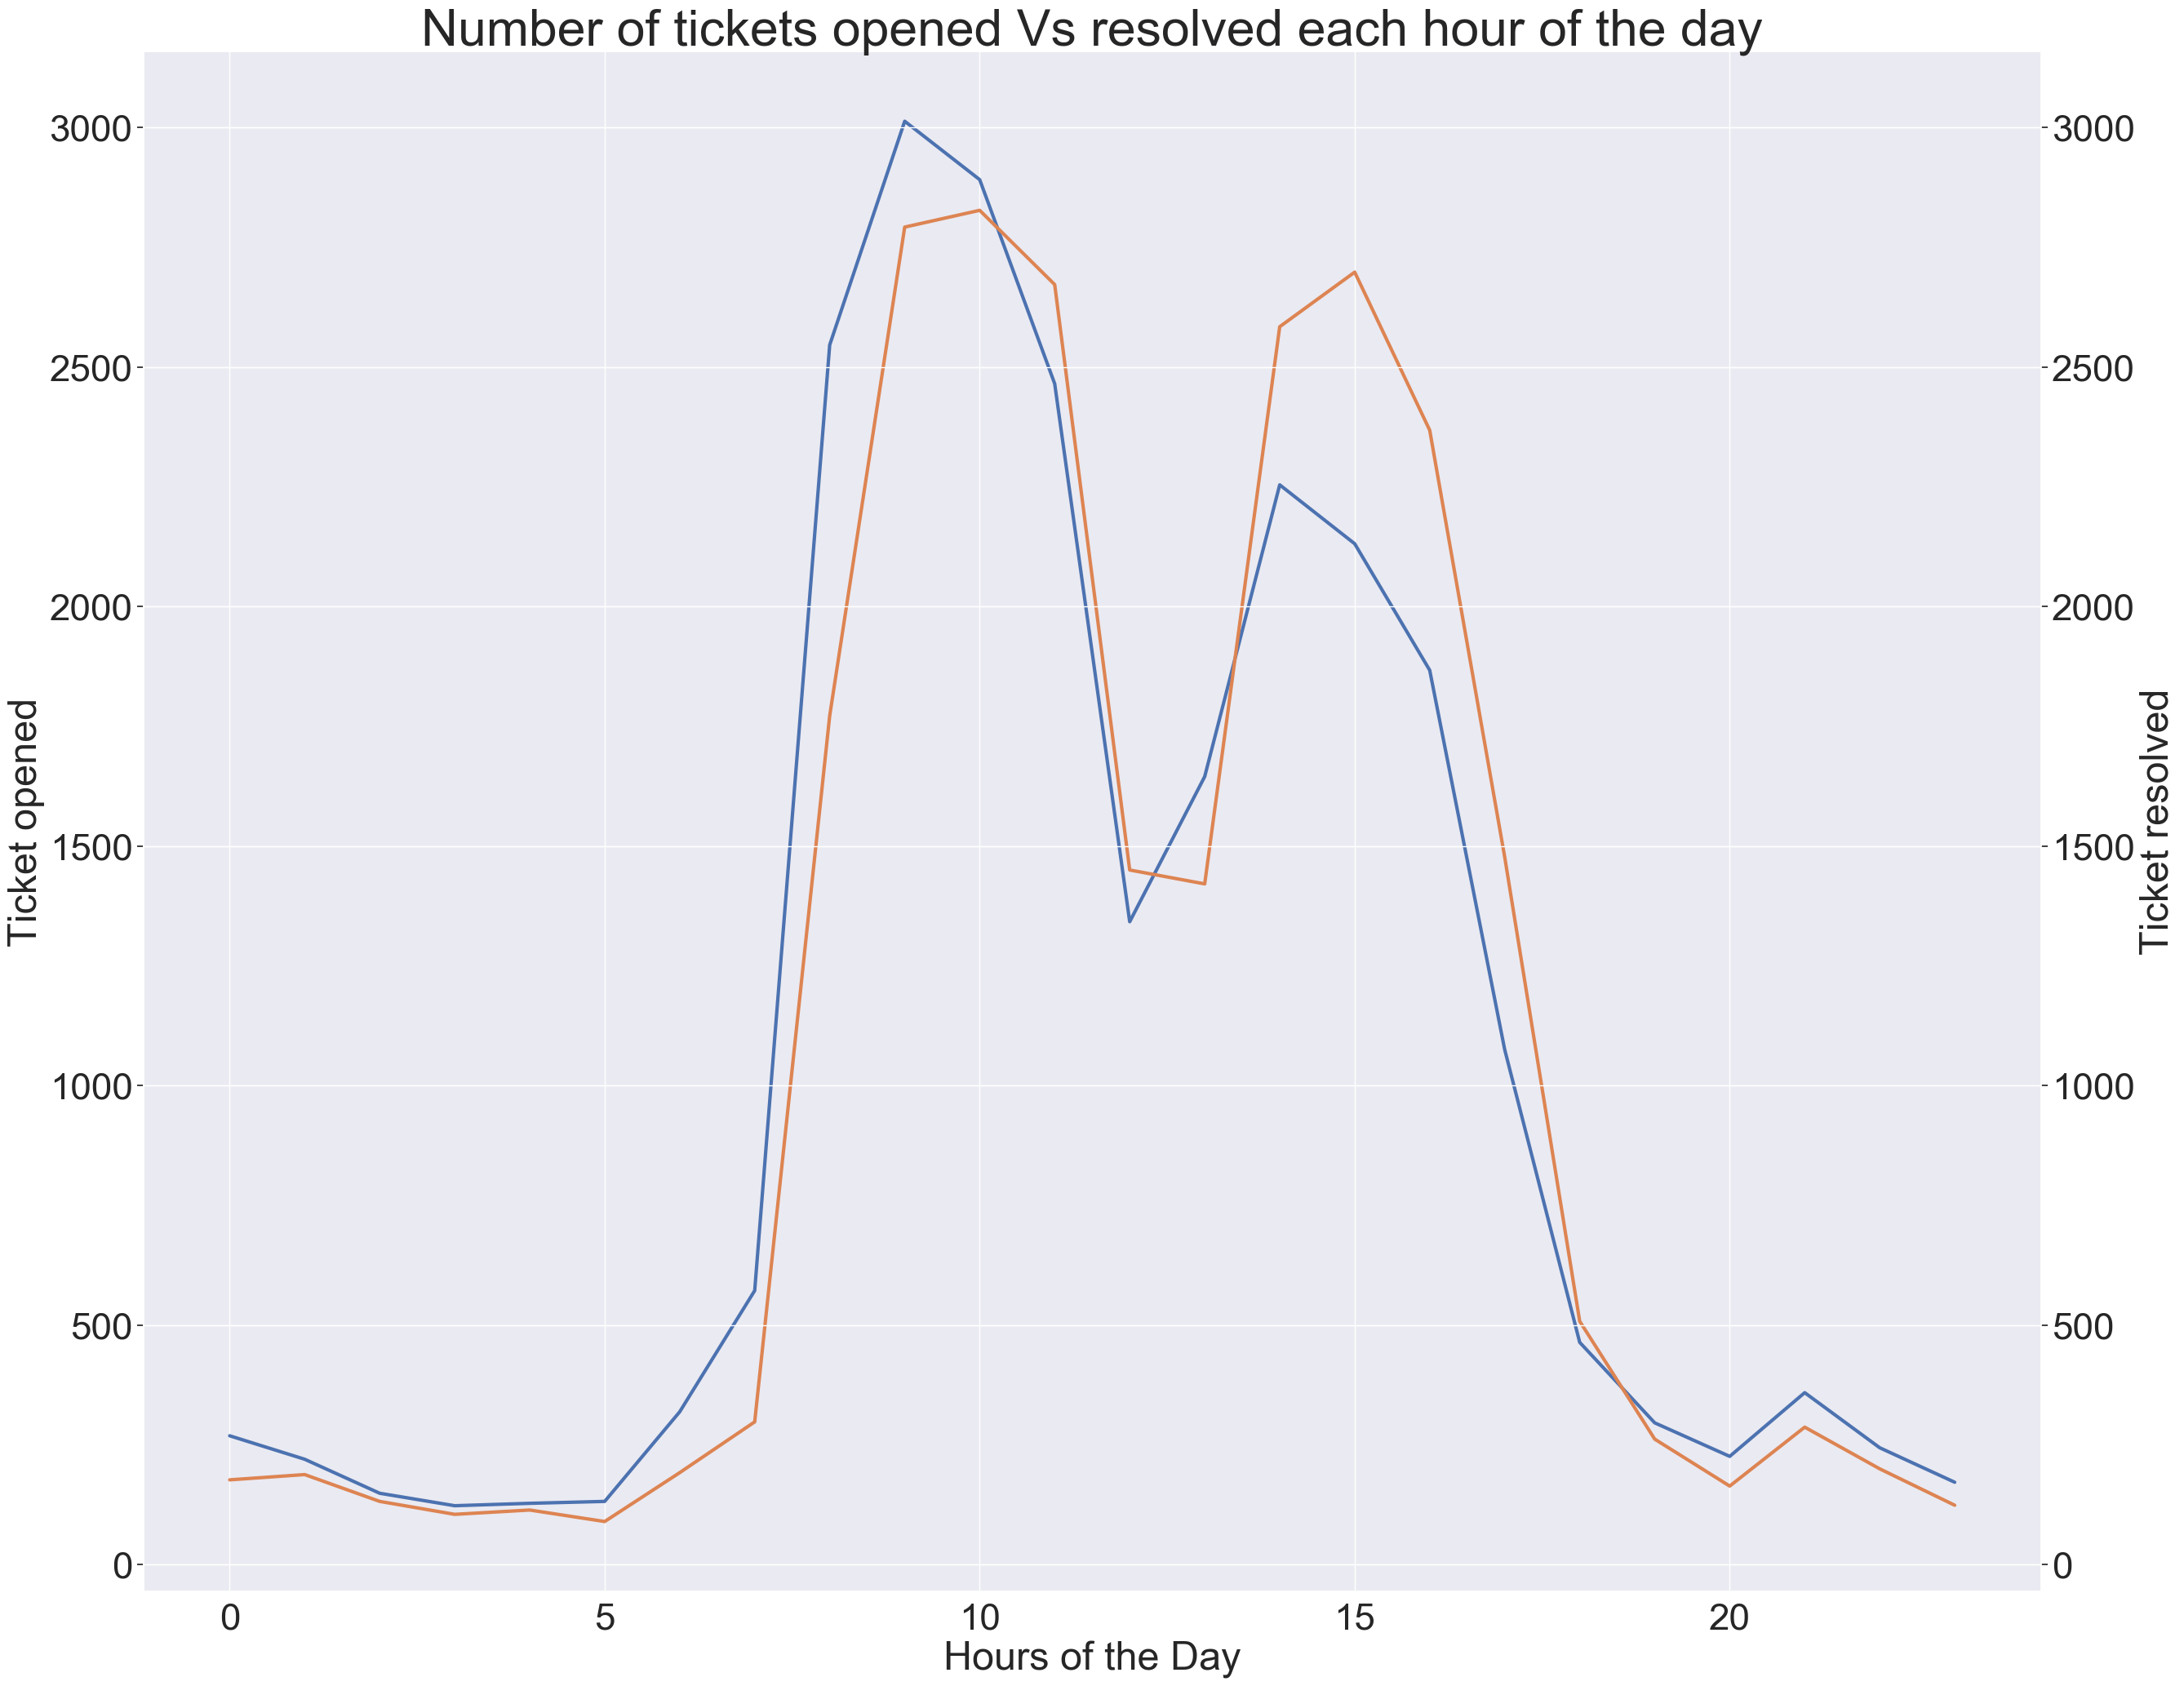

In [196]:
inc_closed['opened_hour']= inc_closed.opened_at.dt.hour
inc_closed['resolved_hour']= inc_closed.resolved_at.dt.hour
fig, ax1 = plt.subplots()
sns.lineplot(data= inc_closed,x=inc_closed['opened_hour'].value_counts().index,y=inc_closed['opened_hour'].value_counts(),ax=ax1,linewidth=3)
sns.lineplot(data= inc_closed,x=inc_closed['resolved_hour'].value_counts().index,y=inc_closed['resolved_hour'].value_counts(),linewidth=3)
ax1.set_ylabel('Ticket opened', fontsize = 35)
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_ylabel('Ticket resolved', fontsize = 35)
ax1.set_xlabel('Hours of the Day', fontsize = 35)
plt.title('Number of tickets opened Vs resolved each hour of the day', fontsize = 45)

Text(0.5, 1.0, 'Number of tickets opened Vs resolved each day of week')

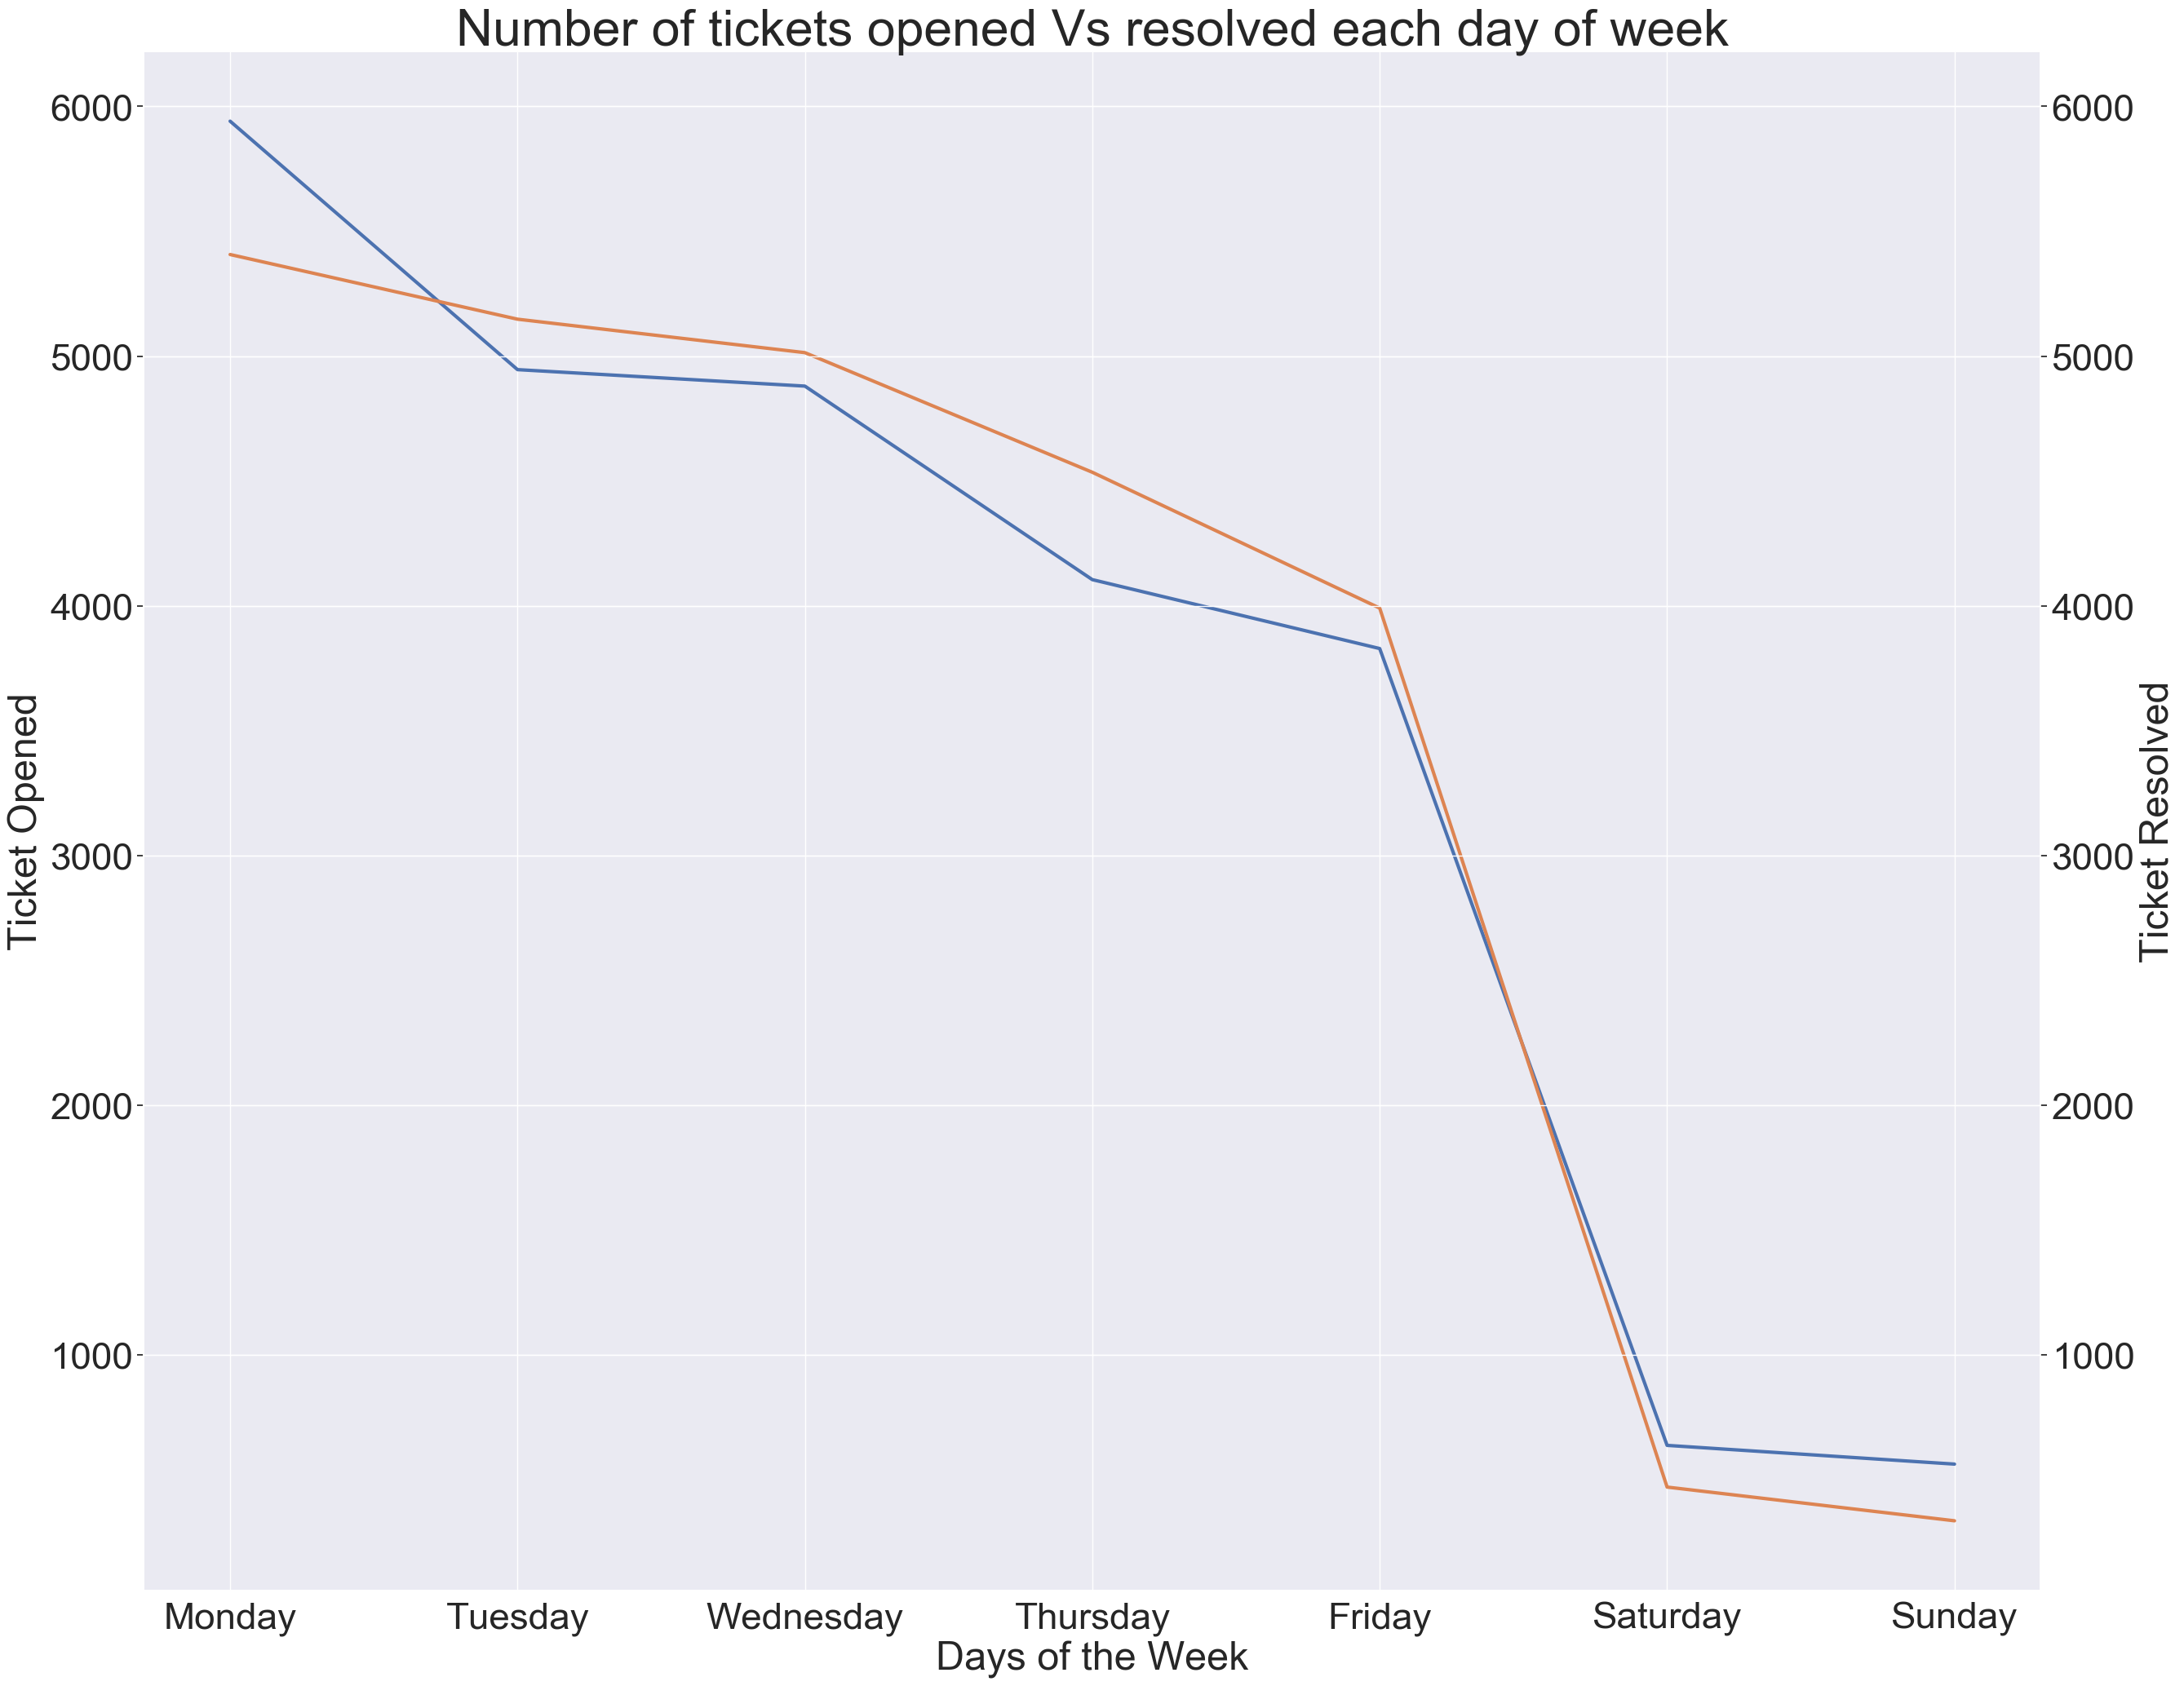

In [197]:
inc_closed['opened_days']= inc_closed.opened_at.dt.weekday_name
inc_closed['resolved_days']= inc_closed.resolved_at.dt.weekday_name

fig, ax1 = plt.subplots()
sns.lineplot(data= inc_closed,x=inc_closed['opened_days'].value_counts().index,y=inc_closed['opened_days'].value_counts(),ax=ax1,sort=False,linewidth=3)
sns.lineplot(data= inc_closed,x=inc_closed['resolved_days'].value_counts().index,y=inc_closed['resolved_days'].value_counts(),sort=False,linewidth=3)
ax1.set_ylabel('Ticket Opened', fontsize = 35)
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_ylabel('Ticket Resolved', fontsize = 35)
ax1.set_xlabel('Days of the Week', fontsize = 35)
plt.title('Number of tickets opened Vs resolved each day of week', fontsize = 45)

Text(0.5, 1.0, 'Trend for Ticket opened each day of the week')

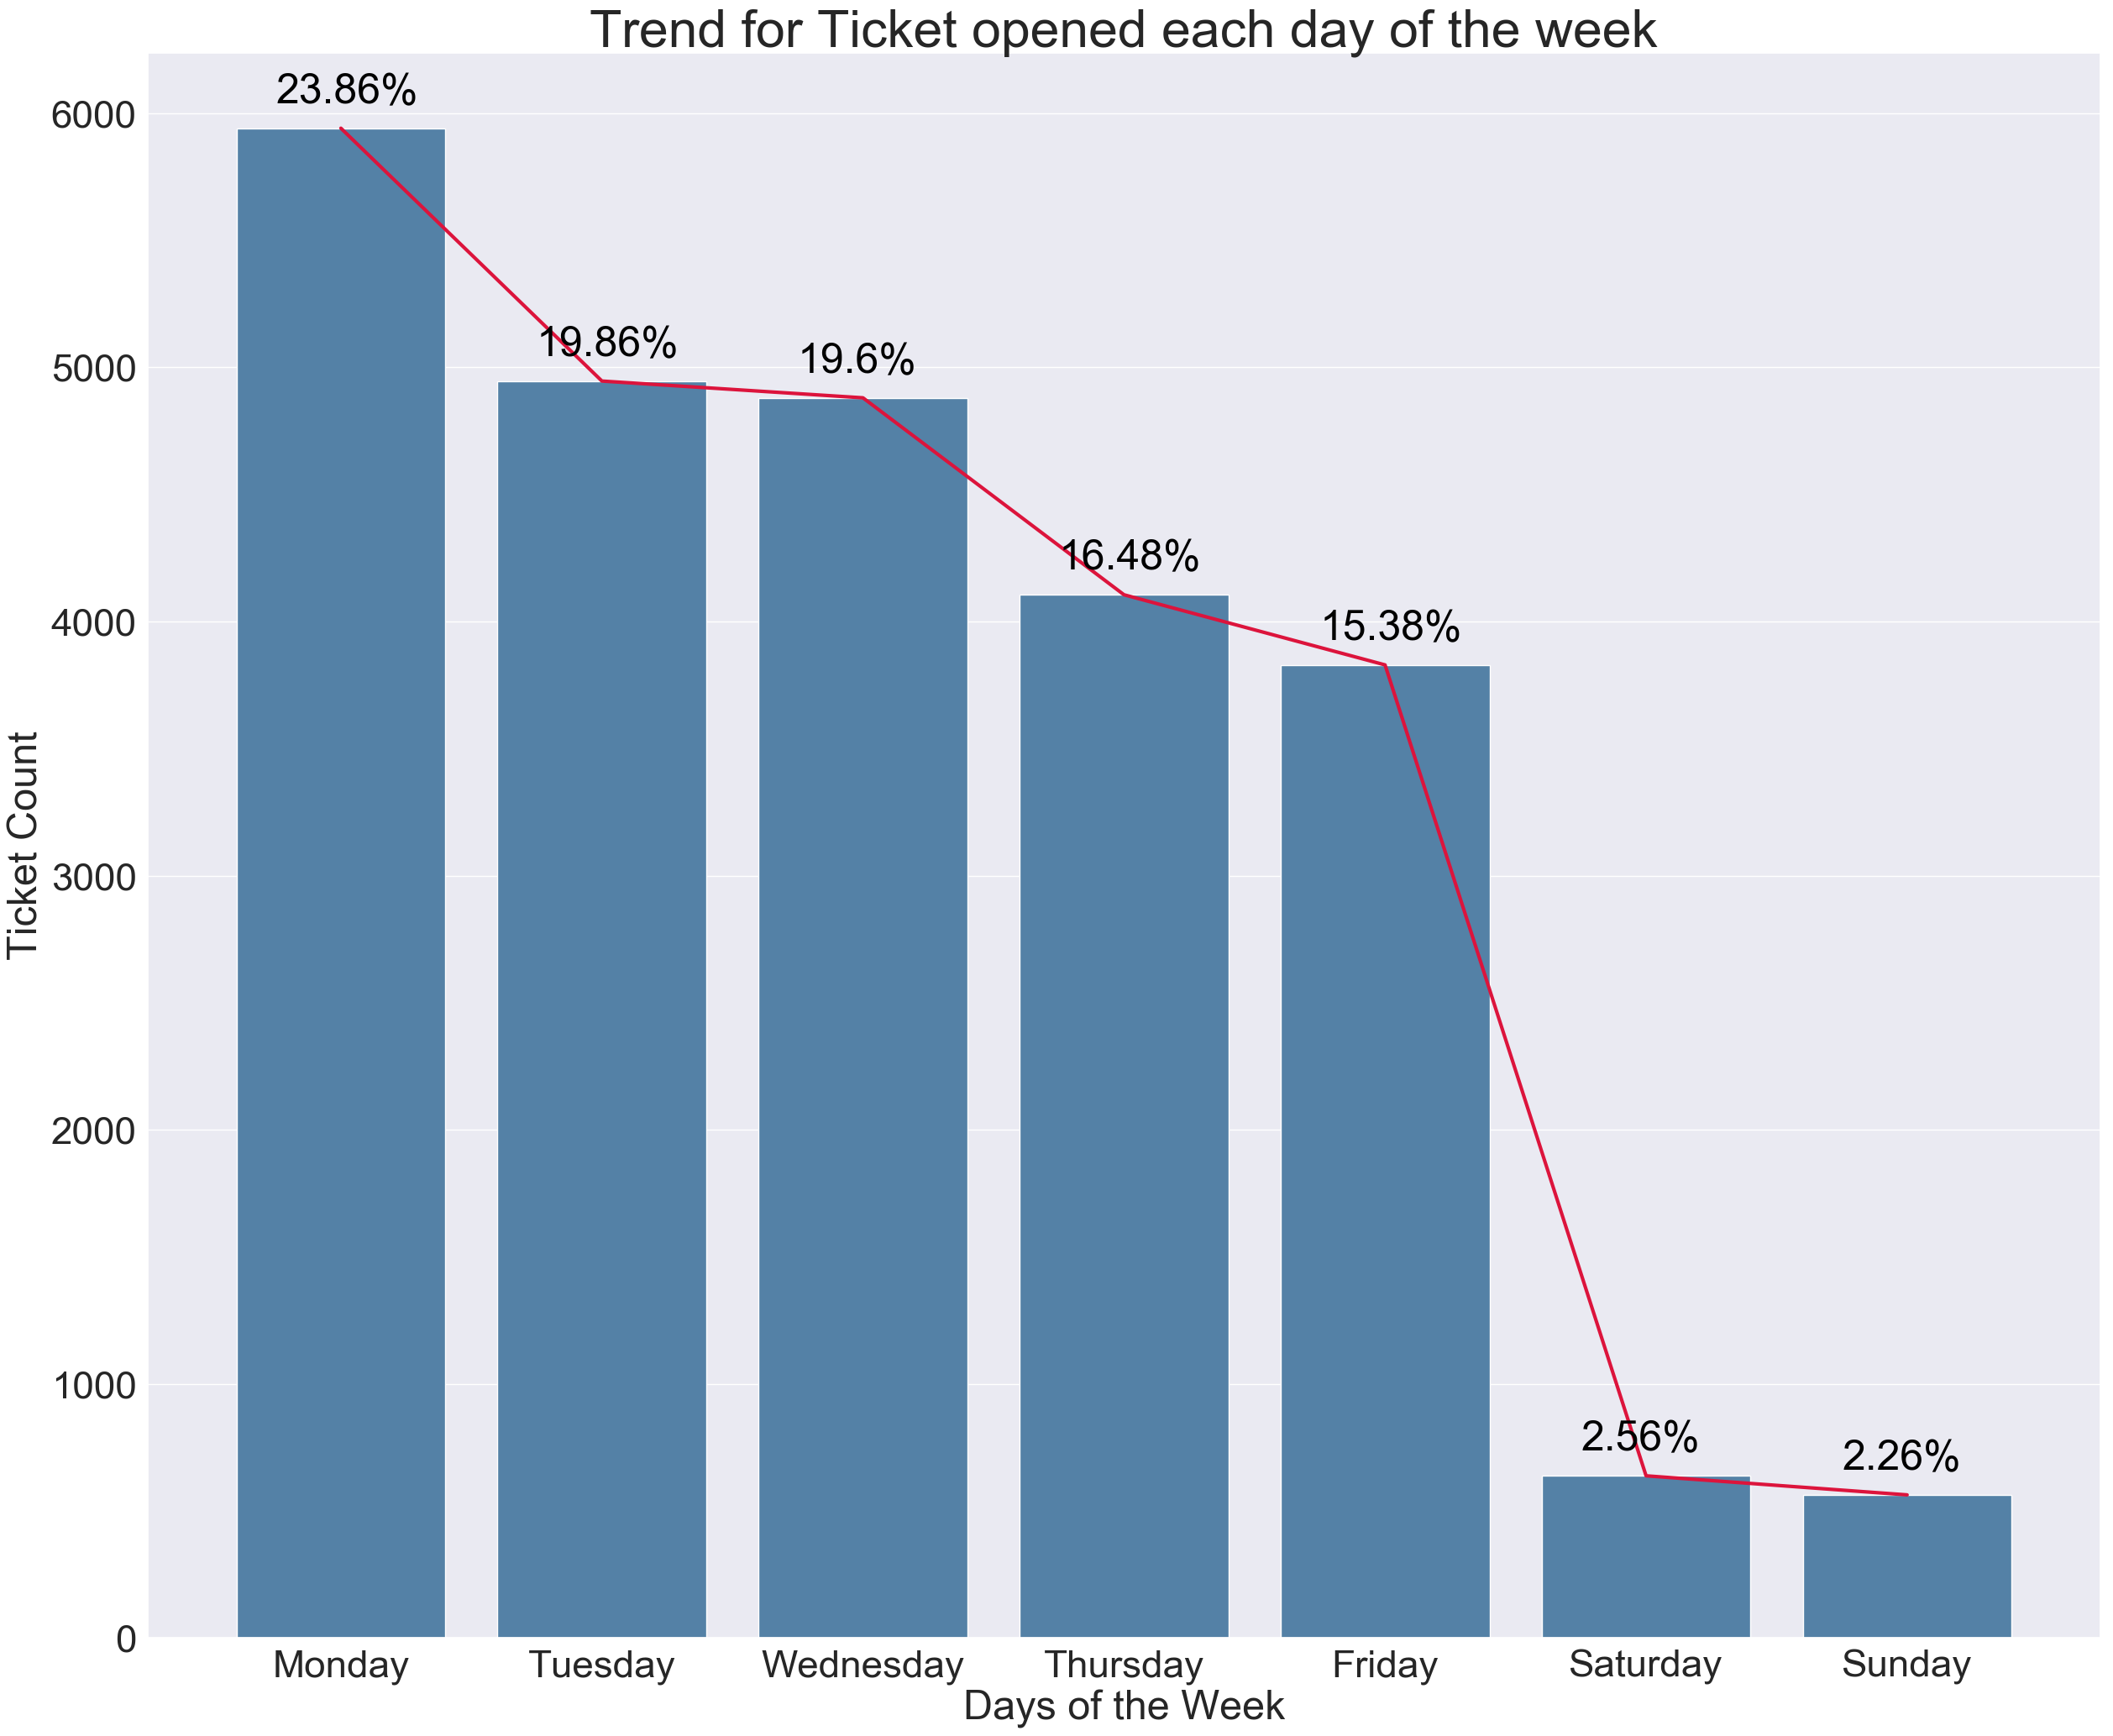

In [198]:
ax = sns.barplot(x=inc_closed['opened_days'].value_counts().index,y=inc_closed['opened_days'].value_counts(),data= inc_closed,color ='steelblue')
sns.lineplot(data= inc_closed,x=inc_closed['opened_days'].value_counts().index,y=inc_closed['opened_days'].value_counts(),sort=False,color= 'crimson',linewidth=3)
bar_perc(ax)
plt.xlabel('Days of the Week', fontsize = 35)
plt.ylabel('Ticket Count', fontsize = 35)
plt.title('Trend for Ticket opened each day of the week', fontsize = 45)

Text(0.5, 1.0, 'Trend for Ticket resolved each day of the week')

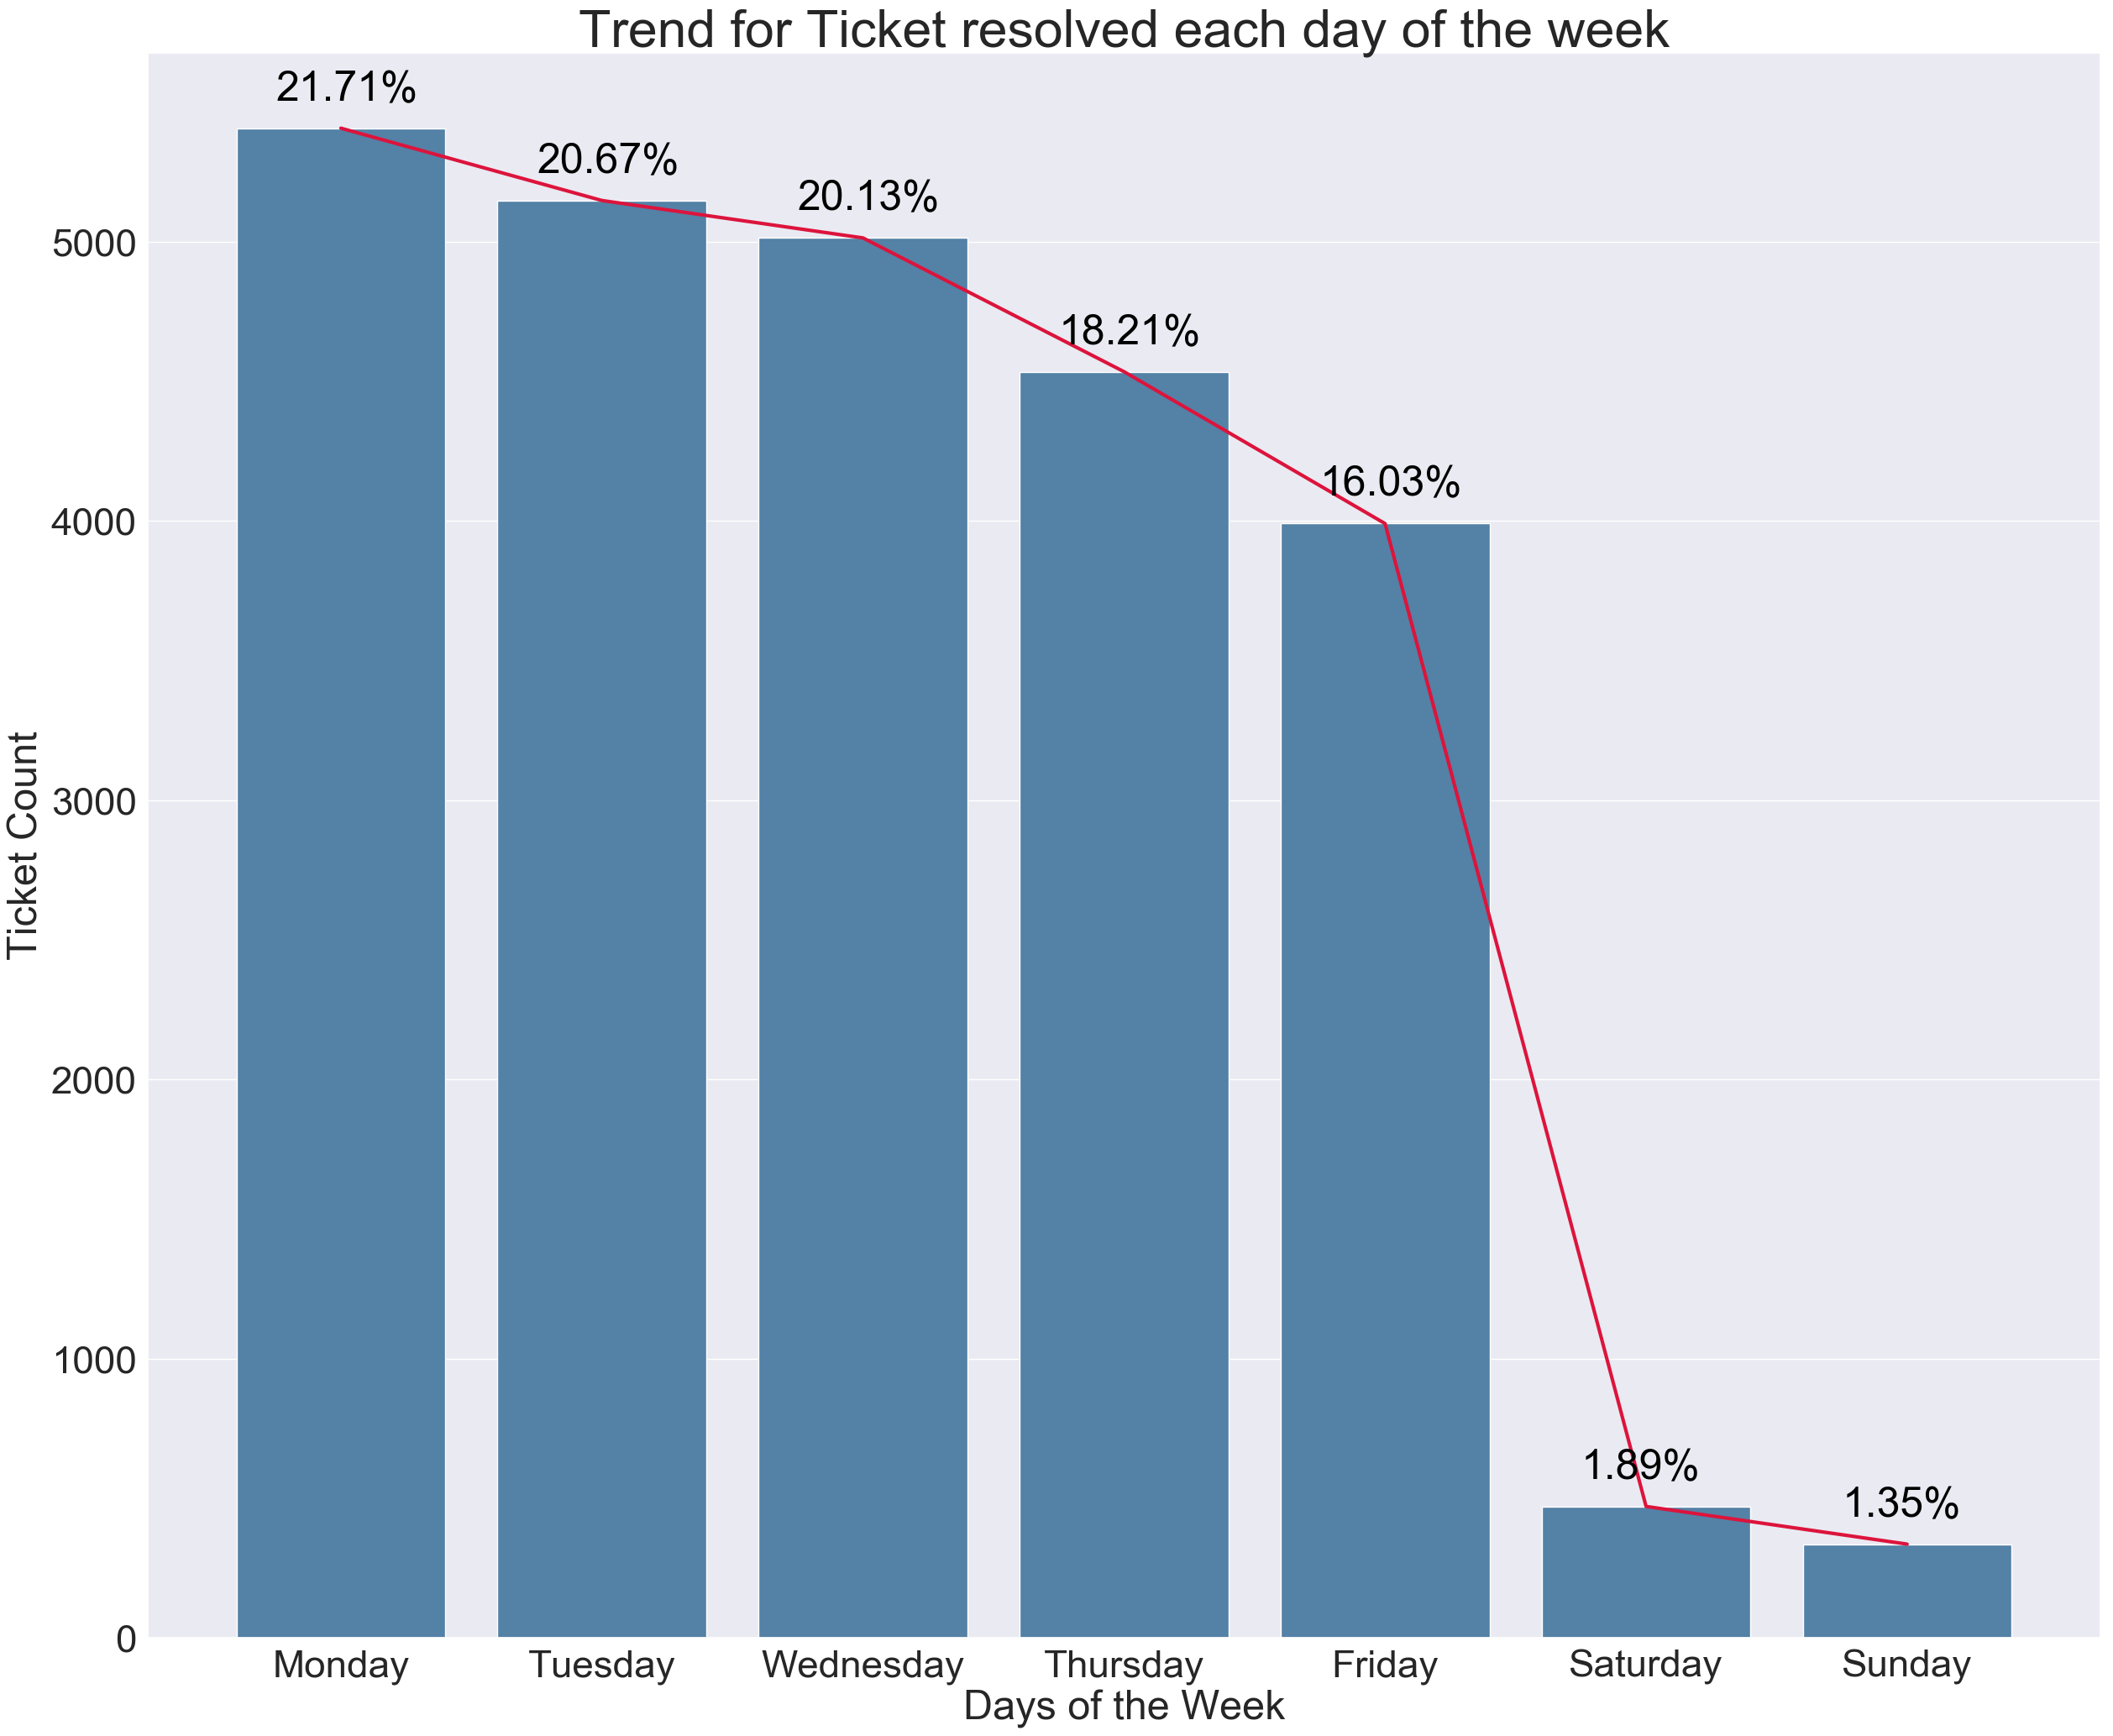

In [199]:
ax = sns.barplot(x=inc_closed['resolved_days'].value_counts().index,y=inc_closed['resolved_days'].value_counts(),data= inc_closed,color ='steelblue')
sns.lineplot(data= inc_closed,x=inc_closed['resolved_days'].value_counts().index,y=inc_closed['resolved_days'].value_counts(),sort=False,color= 'crimson',linewidth=3)
bar_perc(ax)
plt.xlabel('Days of the Week', fontsize = 35)
plt.ylabel('Ticket Count', fontsize = 35)
plt.title('Trend for Ticket resolved each day of the week', fontsize = 45)